## 第8章: ニューラルネット

### 70. 単語ベクトルの和による特徴量

In [1]:
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import re
import torch

def EncoderNN(sign):
    category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
    try:
        code = category_dict[sign]
        return code
    except:
        raise ValueError("Invalid sign: {}".format(sign))

def Text2Vec(text):
    lines = text.split(" ")
    vec_sum = 0
    length = 0
    for line in lines:
        try:
            tmp = model.get_vector(line)
            vec_sum += tmp
            length += 1
        except:
            pass # 単語がモデルにない場合は無視
    return vec_sum / length

def TorchData(data):
    df = pd.read_table("data/{}.txt".format(data))
    sign_regrex = re.compile('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`|＄＃＠£â€™]')
    f_regrex = lambda x:sign_regrex.sub("", x)
    
    df["TITLE"] = df["TITLE"].map(f_regrex)
    X_torch = torch.tensor(df["TITLE"].apply(Text2Vec))
    torch.save(X_torch, "data/X_{}.pt".format(data))

    df["CATEGORY"] = df["CATEGORY"].map(EncoderNN)
    Y_torch = torch.tensor(df["CATEGORY"])
    torch.save(Y_torch, "data/Y_{}.pt".format(data))

model = KeyedVectors.load_word2vec_format("../ch07/GoogleNews-vectors-negative300.bin.gz", binary=True)
TorchData("train")
TorchData("test")
TorchData("valid")

/tmp/ipykernel_3544/1913923098.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_torch = torch.tensor(df["TITLE"].apply(Text2Vec))


### 71. 単層ニューラルネットワークによる予測

In [2]:
import torch.nn as nn

class NetWork(nn.Module):
    def __init__(self, input_feature, output):
        super().__init__()
        self.fc1 = nn.Linear(input_feature, output, bias=False)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

X_train = torch.load("data/X_train.pt", weights_only=True)
model = NetWork(300, 4)
model(X_train)

tensor([[0.2546, 0.2259, 0.2597, 0.2598],
        [0.2892, 0.2115, 0.2449, 0.2544],
        [0.2483, 0.2474, 0.2852, 0.2190],
        ...,
        [0.2621, 0.2592, 0.2526, 0.2260],
        [0.2812, 0.2402, 0.2337, 0.2449],
        [0.2487, 0.2542, 0.2441, 0.2529]], grad_fn=<SoftmaxBackward0>)

### 72. 損失と勾配の計算

In [3]:
loss = nn.CrossEntropyLoss(reduction="mean")
Y_train = torch.load("data/Y_train.pt", weights_only=True)
Y_pred = model(X_train)
CEloss = loss(Y_pred, Y_train)

model.zero_grad()
CEloss.backward()
print("クロスエントロピー損失", CEloss.item())
print("勾配", model.fc1.weight.grad)

クロスエントロピー損失 1.3821297883987427
勾配 tensor([[ 0.0005, -0.0013,  0.0009,  ..., -0.0021, -0.0032,  0.0034],
        [ 0.0007,  0.0009, -0.0017,  ..., -0.0002,  0.0022, -0.0006],
        [-0.0027, -0.0010,  0.0029,  ...,  0.0031, -0.0009, -0.0013],
        [ 0.0015,  0.0013, -0.0021,  ..., -0.0007,  0.0018, -0.0015]])


### 73. 確率的勾配降下法による学習

In [4]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

loss = nn.CrossEntropyLoss(reduction="mean")
Y_train = torch.load("data/Y_train.pt", weights_only=True)

ds = TensorDataset(X_train, Y_train)
DL = DataLoader(ds, batch_size=1, shuffle=True)
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

epoch = 100
for ep in range(epoch):
    for X, Y in DL:
        Y_pred = model(X)
        CEloss = loss(Y_pred, Y)
        optimizer.zero_grad()
        CEloss.backward()
        optimizer.step()

torch.save(model.state_dict(), "data/SingleLayer.pth")

### 74. 正解率の計測

In [4]:
import torch
import torch.nn as nn

class NetWork(nn.Module):
    def __init__(self, input_feature, output):
        super().__init__()
        self.fc1 = nn.Linear(input_feature, output, bias=False)
        nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = NetWork(300, 4)

model.load_state_dict(torch.load("data/SingleLayer.pth", weights_only=True))
X_train = torch.load("data/X_train.pt", weights_only=True)
Y_train = torch.load("data/Y_train.pt", weights_only=True)
X_test = torch.load("data/X_test.pt", weights_only=True)
Y_test = torch.load("data/Y_test.pt", weights_only=True)
X_valid = torch.load("data/X_valid.pt", weights_only=True)
Y_valid = torch.load("data/Y_valid.pt", weights_only=True)

# Y_pred = model(X_test)
# result = torch.max(Y_pred.data, dim=1).indices
# print("テストデータ：", result.eq(Y_test).sum().numpy()/len(Y_pred))
Y_pred = model(X_train)
result = torch.max(Y_pred.data, dim=1).indices
print("学習データ：", result.eq(Y_train).sum().numpy()/len(Y_pred))
Y_pred = model(X_valid)
result = torch.max(Y_pred.data, dim=1).indices
print("評価データ：", result.eq(Y_valid).sum().numpy()/len(Y_pred))

学習データ： 0.9041416791604198
検証データ： 0.8883058470764618


### 75. 損失と正解率のプロット

epoch: 0/100 train_loss: 1.0289251804351807 train_acc: 0.7804535232383808 valid_loss: 1.0315699577331543 valid_acc: 0.7728635682158921
epoch: 10/100 train_loss: 0.9612086415290833 train_acc: 0.7897301349325337 valid_loss: 0.9639726877212524 valid_acc: 0.787856071964018
epoch: 20/100 train_loss: 0.9540923833847046 train_acc: 0.7921664167916042 valid_loss: 0.9572051167488098 valid_acc: 0.7901049475262368
epoch: 30/100 train_loss: 0.9292297959327698 train_acc: 0.8248688155922039 valid_loss: 0.9320820569992065 valid_acc: 0.8215892053973014
epoch: 40/100 train_loss: 0.8937636613845825 train_acc: 0.8778110944527736 valid_loss: 0.8984178900718689 valid_acc: 0.8650674662668666
epoch: 50/100 train_loss: 0.8792718052864075 train_acc: 0.8878373313343328 valid_loss: 0.8854377269744873 valid_acc: 0.8748125937031485
epoch: 60/100 train_loss: 0.8709526658058167 train_acc: 0.8925224887556222 valid_loss: 0.8780094981193542 valid_acc: 0.8800599700149925
epoch: 70/100 train_loss: 0.8653187155723572 train

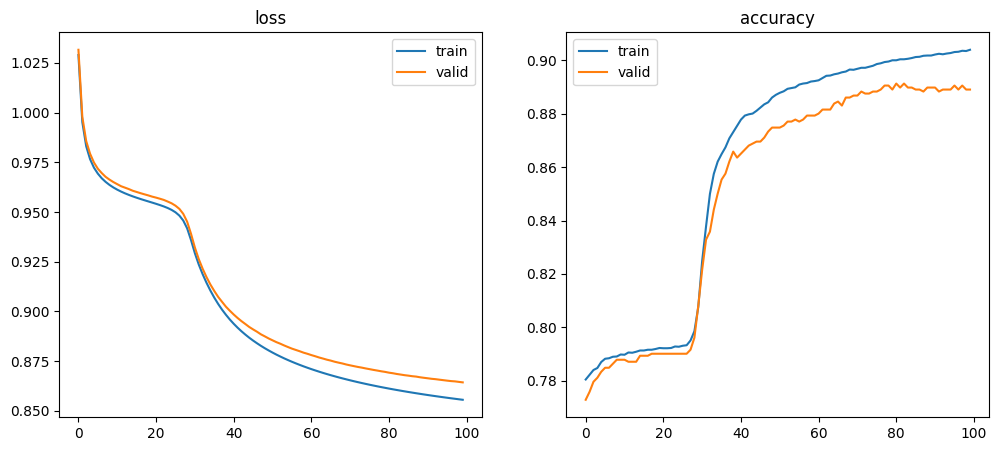

In [7]:
import matplotlib.pyplot as plt

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

model = NetWork(300, 4)

X_train = torch.load("data/X_train.pt", weights_only=True)
Y_train = torch.load("data/Y_train.pt", weights_only=True)
X_valid = torch.load("data/X_valid.pt", weights_only=True)
Y_valid = torch.load("data/Y_valid.pt", weights_only=True)

loss = nn.CrossEntropyLoss(reduction="mean")
ds = TensorDataset(X_train, Y_train)
DL = DataLoader(ds, batch_size=1, shuffle=True)
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

epoch = 100
for ep in range(epoch):
    for X, Y in DL:
        Y_pred = model(X)
        CEloss = loss(Y_pred, Y)
        optimizer.zero_grad()
        CEloss.backward()
        optimizer.step()
    Y_pred_train = model(X_train)
    Y_pred_valid = model(X_valid)
    train_loss.append(loss(Y_pred_train, Y_train).item())
    valid_loss.append(loss(Y_pred_valid, Y_valid).item())
    train_acc.append(torch.max(Y_pred_train.data, dim=1).indices.eq(Y_train).sum().numpy()/len(Y_pred_train))
    valid_acc.append(torch.max(Y_pred_valid.data, dim=1).indices.eq(Y_valid).sum().numpy()/len(Y_pred_valid))
    if ep % 10 == 0:
        print(f"epoch: {ep}/{epoch} train_loss: {train_loss[-1]} train_acc: {train_acc[-1]} valid_loss: {valid_loss[-1]} valid_acc: {valid_acc[-1]}")


ax, fig = plt.subplots(1, 2, figsize=(12, 5))
fig[0].plot(range(epoch), train_loss, label="train")
fig[0].plot(range(epoch), valid_loss, label="valid")
fig[0].legend()
fig[0].set_title("loss")
fig[1].plot(range(epoch), train_acc, label="train")
fig[1].plot(range(epoch), valid_acc, label="valid")
fig[1].legend()
fig[1].set_title("accuracy")
plt.show()
    

### 76. チェックポイント

In [ ]:
X_train = torch.load("data/X_train.pt", weights_only=True)
Y_train = torch.load("data/Y_train.pt", weights_only=True)

loss = nn.CrossEntropyLoss(reduction="mean")
ds = TensorDataset(X_train, Y_train)
DL = DataLoader(ds, batch_size=1, shuffle=True)
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

epoch = 10
for ep in range(epoch):
    for X, Y in DL:
        Y_pred = model(X)
        CEloss = loss(Y_pred, Y)
        optimizer.zero_grad()
        CEloss.backward()
        optimizer.step()
    torch.save(model.state_dict(), f"models/CheckPoint_{ep}.pth")
        

### 77. ミニバッチ化

In [15]:
import time

X_train = torch.load("data/X_train.pt", weights_only=True)
Y_train = torch.load("data/Y_train.pt", weights_only=True)

loss = nn.CrossEntropyLoss(reduction="mean")

ds = TensorDataset(X_train, Y_train)
bs_list = [2**i for i in range(15)]
for bs in bs_list:
	DL = DataLoader(ds, batch_size=bs, shuffle=True)
	optimizer = optim.SGD(params=model.parameters(), lr=0.01)
	model = NetWork(300, 4)
	epoch = 10
	t1 = time.time()
	for ep in range(epoch):
		for X, Y in DL:
			Y_pred = model(X)
			CEloss = loss(Y_pred, Y)
			optimizer.zero_grad()
			CEloss.backward()
			optimizer.step()
	t2 = time.time()
	length = (t2 - t1) / epoch
	print("Batch Size:", bs)
	print("Time:", length)
	print("-" * 50)

Batch Size: 1
Time: 2.945663595199585
--------------------------------------------------
Batch Size: 2
Time: 1.804023027420044
--------------------------------------------------
Batch Size: 4
Time: 0.9437390565872192
--------------------------------------------------
Batch Size: 8
Time: 0.5144207000732421
--------------------------------------------------
Batch Size: 16
Time: 0.29583852291107177
--------------------------------------------------
Batch Size: 32
Time: 0.18226947784423828
--------------------------------------------------
Batch Size: 64
Time: 0.1293801784515381
--------------------------------------------------
Batch Size: 128
Time: 0.10205602645874023
--------------------------------------------------
Batch Size: 256
Time: 0.08488681316375732
--------------------------------------------------
Batch Size: 512
Time: 0.08210186958312989
--------------------------------------------------
Batch Size: 1024
Time: 0.06484184265136719
---------------------------------------------

### 78. GPU上での学習

In [1]:
import torch
torch.cuda.is_available()

False

### 79. 多層ニューラルネットワーク

In [6]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MultiNetWork(nn.Module):
    def __init__(self, input_feature, output):
        super().__init__()
        self.fc1 = nn.Linear(input_feature, 300, bias=True)
        self.fc2 = nn.Linear(300, output, bias=True)
        # self.fc3 = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = self.fc3(x)
        return x

X_train = torch.load("data/X_train.pt", weights_only=True)
Y_train = torch.load("data/Y_train.pt", weights_only=True)
X_test = torch.load("data/X_test.pt", weights_only=True)
Y_test = torch.load("data/Y_test.pt", weights_only=True)
X_valid = torch.load("data/X_valid.pt", weights_only=True)
Y_valid = torch.load("data/Y_valid.pt", weights_only=True)

loss = nn.CrossEntropyLoss(reduction="mean")
model = MultiNetWork(300, 4)
ds = TensorDataset(X_train, Y_train)
DL = DataLoader(ds, batch_size=1, shuffle=True)
optimizer = optim.SGD(params=model.parameters(), lr=0.001)

epoch = 100
lowest_loss = 1e6
for ep in range(epoch):
    for X, Y in DL:
        Y_pred = model(X)
        CEloss = loss(Y_pred, Y)
        optimizer.zero_grad()
        CEloss.backward()
        optimizer.step()
    if lowest_loss > CEloss:
        torch.save(model.state_dict(), "data/MultiLayer.pth")
        lowest_loss = CEloss

model.load_state_dict(torch.load("data/MultiLayer.pth", weights_only=True))

Y_pred = model(X_train)
result = torch.max(Y_pred.data, dim=1).indices
print("学習データ：", result.eq(Y_train).sum().numpy()/len(Y_pred))
Y_pred = model(X_valid)
result = torch.max(Y_pred.data, dim=1).indices
print("評価データ：", result.eq(Y_valid).sum().numpy()/len(Y_pred))

KeyboardInterrupt: 